In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Task 1

In [3]:
file_path = "renttherunway_final_data.json"
data = pd.read_json(file_path, lines=True)

In [4]:
data.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [5]:
def clean_weight(weight):
    if isinstance(weight, str):
        return float(weight.replace("lbs", ""))
    return weight

def clean_height(height):
    if isinstance(height, str):
        match = re.match(r"(\d+)' (\d+)\"", height)
        if match:
            feet = int(match.group(1))
            inches = int(match.group(2))
            return feet * 12 + inches
    return height

data["weight"] = data["weight"].apply(clean_weight)
data["height"] = data["height"].apply(clean_height)
data["age"] = pd.to_numeric(data["age"], errors="coerce")

data["weight"].fillna(data["weight"].mean(), inplace=True)
data["bust size"].fillna("Unknown", inplace=True)
data["body type"].fillna("Unknown", inplace=True)

data["review_length"] = data["review_text"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# data_cleaned = data.drop(columns =["review_date", "age", "rented for", "user_id", "item_id", "review_summary"])
# data_cleaned.head(10)

C:\Users\kanet\AppData\Local\Temp\ipykernel_57248\2087181326.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["weight"].fillna(data["weight"].mean(), inplace=True)
C:\Users\kanet\AppData\Local\Temp\ipykernel_57248\2087181326.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

,fit,bust size,weight,rating,review_text,body type,category,height,size,review_length
0,fit,34d,137.000000,10.0,An adorable romper! Belt and zipper were a lit...,hourglass,romper,68.0,14,221
1,fit,34b,132.000000,10.0,I rented this dress for a photo shoot. The the...,straight & narrow,gown,66.0,12,221
2,fit,Unknown,137.391709,10.0,This hugged in all the right places! It was a ...,Unknown,sheath,64.0,4,198
3,fit,34c,135.000000,8.0,I rented this for my company's black tie award...,pear,dress,65.0,8,465
4,fit,34b,145.000000,10.0,I have always been petite in my upper body and...,athletic,gown,69.0,12,559
5,fit,32b,138.000000,8.0,Didn't actually wear it. It fit perfectly. The...,athletic,dress,68.0,8,195
6,fit,34c,112.000000,10.0,This dress is so sweet. I loved the print. The...,hourglass,dress,63.0,4,158
7,fit,34d+,118.000000,10.0,Fit was great. Maybe a little tight under the ...,full bust,dress,63.0,8,52
8,fit,36d,137.391709,10.0,I was nervous of it looking cheap when it arri...,full bust,gown,66.0,21,254
9,fit,32b,114.000000,10.0,The dress was very flattering and fit perfectl...,petite,gown,63.0,1,708


In [7]:
# Basic statistics of numerical columns
print("\nNumerical Column Statistics:")
print(data[["height", "weight", "age", "rating", "size"]].describe())


Numerical Column Statistics:
              height         weight            age         rating  \
count  191867.000000  192544.000000  191584.000000  192462.000000   
mean       65.310621     137.391709      33.871017       9.092371   
std         2.663480      20.122771       8.058083       1.430044   
min        54.000000      50.000000       0.000000       2.000000   
25%        63.000000     125.000000      29.000000       8.000000   
50%        65.000000     137.391709      32.000000      10.000000   
75%        67.000000     145.000000      37.000000      10.000000   
max        78.000000     300.000000     117.000000      10.000000   

                size  
count  192544.000000  
mean       12.245175  
std         8.494877  
min         0.000000  
25%         8.000000  
50%        12.000000  
75%        16.000000  
max        58.000000  


In [8]:
# Distribution of fit categories
print("\nFit Distribution:")
print(data["fit"].value_counts(normalize=True) * 100)


Fit Distribution:
fit
fit      73.779500
small    13.388628
large    12.831872
Name: proportion, dtype: float64


In [9]:
# Distribution of categories
print("\nTop 10 Clothing Categories:")
print(data["category"].value_counts().head(10))


Top 10 Clothing Categories:
category
dress       92884
gown        44381
sheath      19316
shift        5365
jumpsuit     5184
top          4931
maxi         3443
romper       3070
jacket       2404
mini         1751
Name: count, dtype: int64


In [10]:
# Distribution of body types
print("\nBody Type Distribution:")
print(data["body type"].value_counts())


Body Type Distribution:
body type
hourglass            55349
athletic             43667
pear                 22135
petite               22131
full bust            15006
straight & narrow    14742
Unknown              14637
apple                 4877
Name: count, dtype: int64


In [11]:
# Average ratings by fit
print("\nAverage Rating by Fit:")
print(data.groupby("fit")["rating"].mean())


Average Rating by Fit:
fit
fit      9.308469
large    8.551942
small    8.419615
Name: rating, dtype: float64


In [12]:
# Correlation analysis for numerical features
numerical_cols = ["height", "weight", "age", "rating", "size", "review_length"]
correlation_matrix = data[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                 height    weight       age    rating      size  review_length
height         1.000000  0.351348 -0.007465  0.001746  0.228875       0.009542
weight         0.351348  1.000000  0.061360 -0.020685  0.732737       0.036429
age           -0.007465  0.061360  1.000000 -0.035280  0.155687      -0.090307
rating         0.001746 -0.020685 -0.035280  1.000000 -0.036731      -0.014237
size           0.228875  0.732737  0.155687 -0.036731  1.000000       0.040032
review_length  0.009542  0.036429 -0.090307 -0.014237  0.040032       1.000000


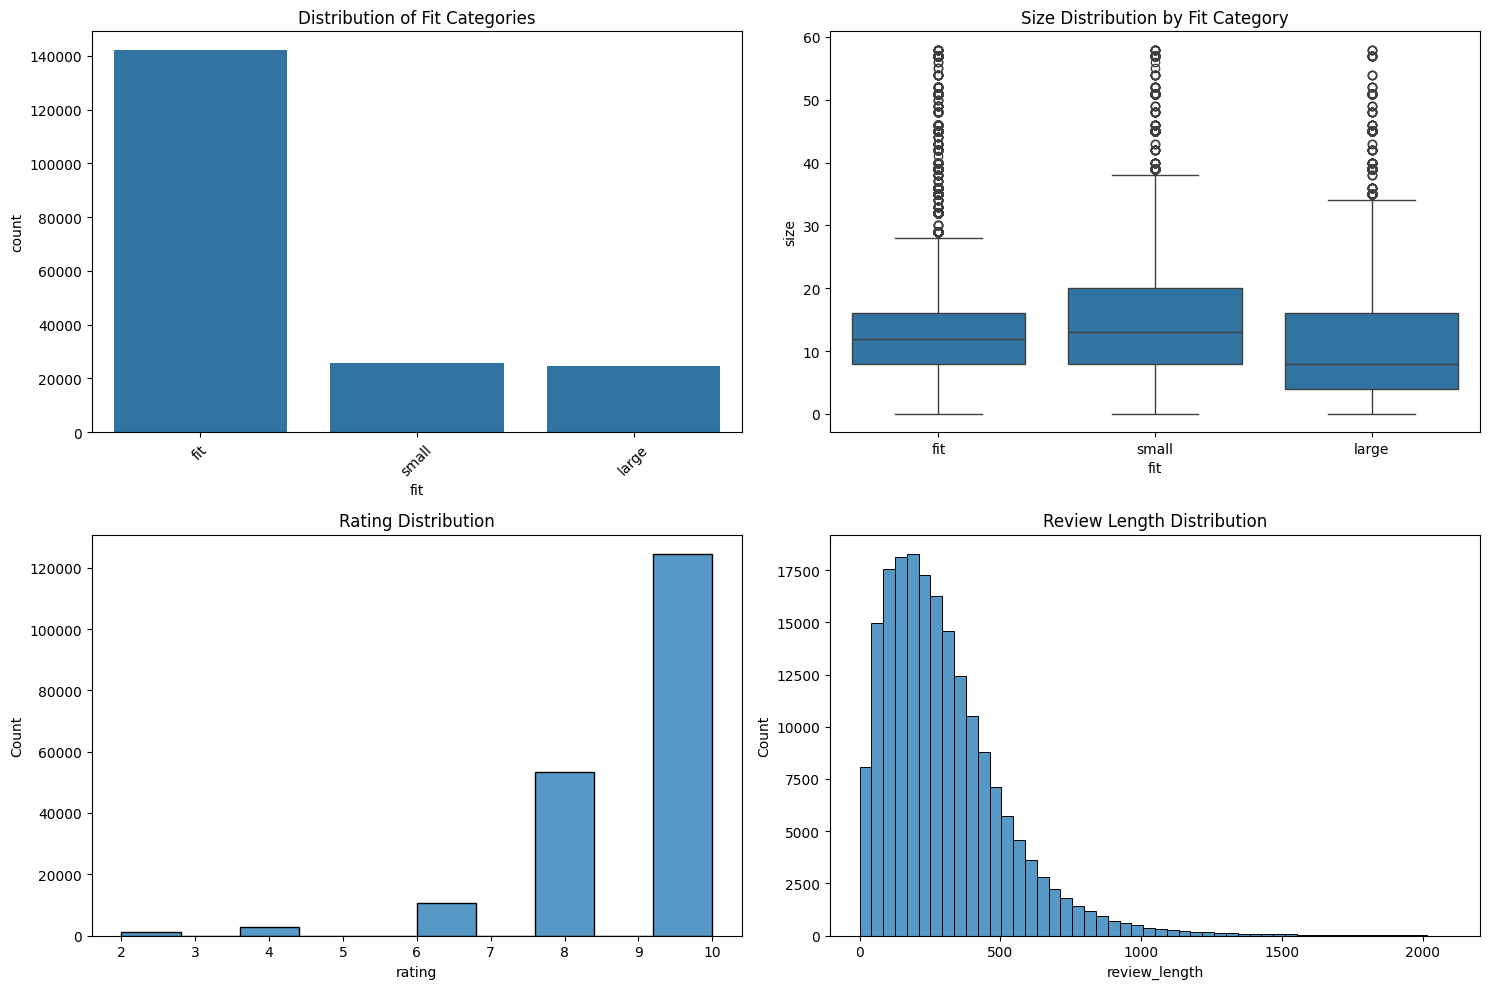

In [14]:
# Visualization of key distributions
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of Fit
plt.subplot(2, 2, 1)
sns.countplot(data=data, x="fit")
plt.title("Distribution of Fit Categories")
plt.xticks(rotation=45)

# Plot 2: Box plot of Size by Fit
plt.subplot(2, 2, 2)
sns.boxplot(data=data, x="fit", y="size")
plt.title("Size Distribution by Fit Category")

# Plot 3: Rating Distribution
plt.subplot(2, 2, 3)
sns.histplot(data=data, x="rating", bins=10)
plt.title("Rating Distribution")

# Plot 4: Review Length Distribution
plt.subplot(2, 2, 4)
sns.histplot(data=data, x="review_length", bins=50)
plt.title("Review Length Distribution")

plt.tight_layout()
plt.show()


In [15]:
# Additional analysis for size and measurements
print("\nSize Distribution by Category:")
size_category = pd.crosstab(data["size"], data["category"])
print(size_category)

# Analyze review text patterns
print("\nAverage Review Length by Fit:")
print(data.groupby("fit")["review_length"].mean())


Size Distribution by Category:
category  ballgown  blazer  blouse  blouson  bomber  buttondown  caftan  cami  \
size                                                                            
0                0       0       0        0       0           0       0     0   
1                0      73      25        4       5           0       0     1   
2                0       1       3        0       0           0       0     0   
3                0       0       0        0       0           0       0     0   
4                1     142     100        1      17           0       1     4   
5                0       0       0        0       0           0       0     0   
6                0       0       0        0       0           0       0     0   
7                0       0       0        0       0           0       0     0   
8                1     189     191        4      39           0       2     4   
9                0       0       0        0       0           0       0     0

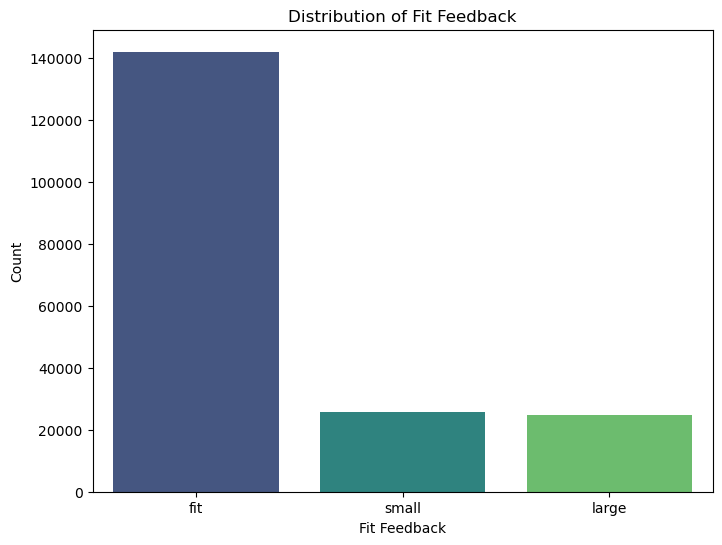

In [14]:
# Distribution of Fit Feedback
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, x="fit", palette="viridis")
plt.title("Distribution of Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Count")
plt.show()



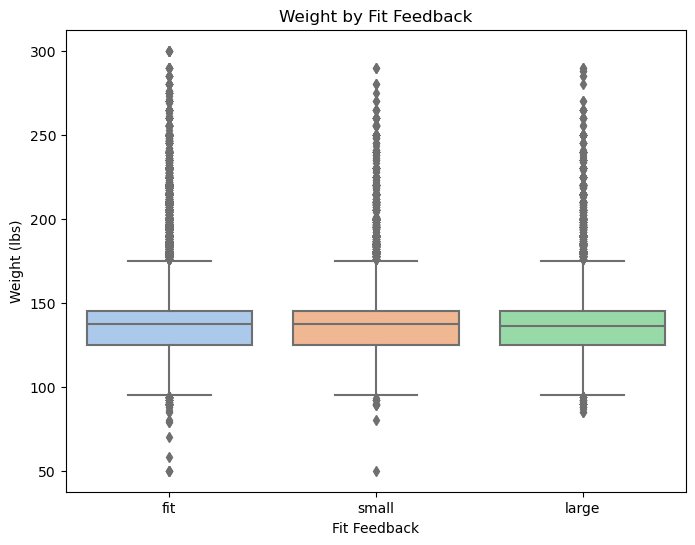

In [15]:
# Weight by Fit Feedback
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_cleaned, x="fit", y="weight", palette="pastel")
plt.title("Weight by Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Weight (lbs)")
plt.show()



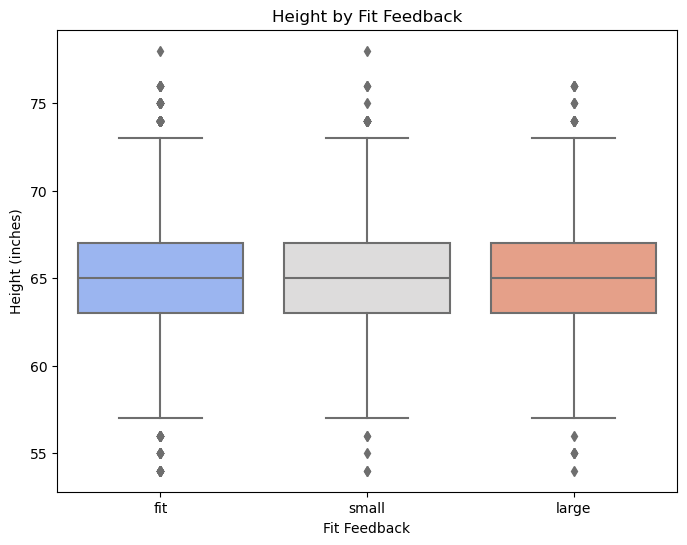

In [16]:
# Height by Fit Feedback
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_cleaned, x="fit", y="height", palette="coolwarm")
plt.title("Height by Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Height (inches)")
plt.show()



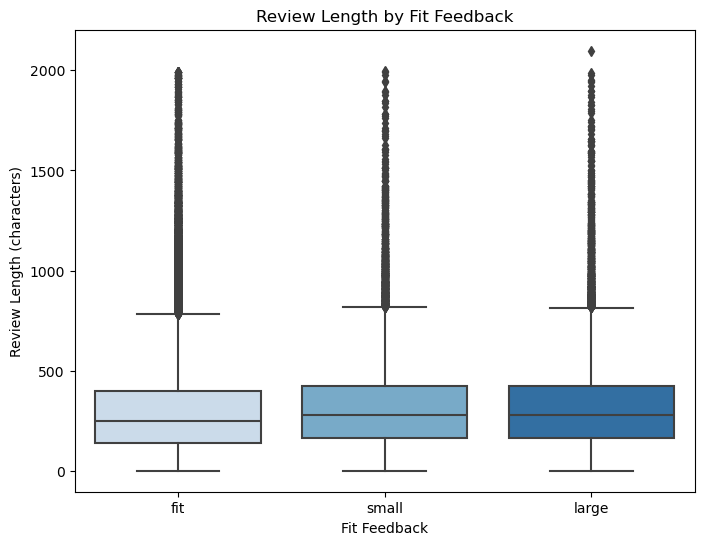

In [17]:
# Review Length by Fit Feedback
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_cleaned, x="fit", y="review_length", palette="Blues")
plt.title("Review Length by Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Review Length (characters)")
plt.show()

### Generate Cleaned CSV

In [ ]:
# Save cleaned data for next steps
data_cleaned = data.drop(columns=["review_date", "age", "rented for", "user_id", "item_id"])
data_cleaned.to_csv("cleaned_rtr_data.csv", index=False)

# Task 2

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Load the cleaned data
data = pd.read_csv("cleaned_rtr_data.csv")

# Define the prediction task
print("Prediction Task: Predict clothing fit (fit/small/large) based on user measurements and review data")
print("\nTarget Variable Distribution:")
print(data["fit"].value_counts(normalize=True))

# Feature Engineering

# 1. Process bust size
def process_bust_size(bust):
    if pd.isna(bust) or bust == "Unknown":
        return None, None
    match = re.match(r"(\d+)([A-Za-z]+)", str(bust))
    if match:
        number = int(match.group(1))
        letter = match.group(2).upper()
        letter_value = ord(letter[0]) - ord('A') + 1
        return number, letter_value
    return None, None

data[["bust_number", "bust_letter_value"]] = pd.DataFrame(
    data["bust size"].apply(process_bust_size).tolist(),
    index=data.index
)

# 2. Calculate BMI
data["bmi"] = (data["weight"] * 703) / (data["height"] ** 2)

# 3. Process categories
label_encoder = LabelEncoder()
data["category_encoded"] = label_encoder.fit_transform(data["category"])
category_dummies = pd.get_dummies(data["category"], prefix="category")

# 4. Process body types
body_type_dummies = pd.get_dummies(data["body type"], prefix="body_type")

# 5. Text feature engineering
# Basic text features
data["review_word_count"] = data["review_text"].fillna("").str.split().str.len()
data["review_avg_word_length"] = data["review_text"].fillna("").apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x)) > 0 else 0
)

# TF-IDF for review text
tfidf = TfidfVectorizer(
    max_features=100,  # Adjust based on your needs
    stop_words='english',
    ngram_range=(1, 2)
)
review_tfidf = tfidf.fit_transform(data["review_text"].fillna(""))
tfidf_df = pd.DataFrame(
    review_tfidf.toarray(),
    columns=[f"tfidf_{i}" for i in range(review_tfidf.shape[1])]
)

# Combine all features
feature_columns = [
    # Numerical features
    "height", "weight", "bmi", "size",
    "bust_number", "bust_letter_value",
    "review_length", "review_word_count", "review_avg_word_length",
    "rating"
]

# Create final feature matrix
X = pd.concat([
    data[feature_columns],
    category_dummies,
    body_type_dummies,
    tfidf_df
], axis=1)

# Target variable
y = data["fit"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
numerical_features = feature_columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Print feature information
print("\nFinal Feature Set:")
print(f"Total number of features: {X.shape[1]}")
print("\nFeature categories:")
print(f"- Numerical features: {len(numerical_features)}")
print(f"- Category features: {len(category_dummies.columns)}")
print(f"- Body type features: {len(body_type_dummies.columns)}")
print(f"- Text features: {review_tfidf.shape[1]}")

# Save processed data for modeling
X_train_scaled.to_csv("X_train.csv", index=False)
X_test_scaled.to_csv("X_test.csv", index=False)
pd.Series(y_train).to_csv("y_train.csv", index=False)
pd.Series(y_test).to_csv("y_test.csv", index=False)

# Print evaluation strategy
print("\nEvaluation Strategy:")
print("- Metrics to be used: Accuracy, Precision, Recall, F1-Score")
print("- Stratified K-fold cross-validation will be used")
print("- Separate test set held out for final evaluation")
print(f"- Training set size: {len(X_train)}")
print(f"- Test set size: {len(X_test)}")

# Print baseline metrics
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_scaled, y_train)
print("\nBaseline (Most Frequent Class) Accuracy:", 
      dummy.score(X_test_scaled, y_test))

Prediction Task: Predict clothing fit (fit/small/large) based on user measurements and review data

Target Variable Distribution:
fit
fit      0.737795
small    0.133886
large    0.128319
Name: proportion, dtype: float64

Final Feature Set:
Total number of features: 186

Feature categories:
- Numerical features: 10
- Category features: 68
- Body type features: 8
- Text features: 100

Evaluation Strategy:
- Metrics to be used: Accuracy, Precision, Recall, F1-Score
- Stratified K-fold cross-validation will be used
- Separate test set held out for final evaluation
- Training set size: 154035
- Test set size: 38509

Baseline (Most Frequent Class) Accuracy: 0.7378015528837415
